# Modeling

In [37]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import yaml
import json
import joblib
from tqdm import tqdm
from datetime import datetime

import os
import copy
import hashlib
import pandas as pd

## Load Configuration File

In [4]:
os.chdir('/home/febbyngrni/telco_churn')
os.getcwd()

'/home/febbyngrni/telco_churn'

In [5]:
params_dir = 'config/config.yaml'

In [6]:
def load_params(params_dir):
    with open(params_dir, 'r') as file:
        params = yaml.safe_load(file)

    return params

In [7]:
params = load_params(params_dir)

## Load Dataset

In [8]:
def time_stamp():
    return datetime.now()

In [9]:
PRINT_DEBUG = params['print_debug']

def print_debug(message: str):
    if PRINT_DEBUG == True:
        print(time_stamp(), message)

In [10]:
def load_rus_data(params: dict) -> pd.DataFrame:
    X_rus = joblib.load(params['data_rus_path'][0])
    y_rus = joblib.load(params['data_rus_path'][1])

    return X_rus, y_rus

def load_ros_data(params: dict) -> pd.DataFrame:
    X_ros = joblib.load(params['data_ros_path'][0])
    y_ros = joblib.load(params['data_ros_path'][1])

    return X_ros, y_ros

def load_sm_data(params: dict) -> pd.DataFrame:
    X_sm = joblib.load(params['data_sm_path'][0])
    y_sm = joblib.load(params['data_sm_path'][1])

    return X_sm, y_sm

def load_valid_set(params: dict) -> pd.DataFrame:
    X_valid = joblib.load(params['valid_feng_set_path'][0])
    y_valid = joblib.load(params['valid_feng_set_path'][1])

    return X_valid, y_valid

def load_test_set(params: dict) -> pd.DataFrame:
    X_test = joblib.load(params['test_feng_set_path'][0])
    y_test = joblib.load(params['test_feng_set_path'][1])

    return X_test, y_test

In [11]:
def load_dataset(config_file):
    print_debug('Load data')

    X_rus, y_rus = load_rus_data(config_file)
    X_ros, y_ros = load_ros_data(config_file)
    X_sm, y_sm = load_sm_data(config_file)
    X_valid, y_valid = load_valid_set(config_file)
    X_test, y_test = load_test_set(config_file)

    print_debug('All datasets successfully loaded')

    return X_rus, y_rus, X_ros, y_ros, X_sm, y_sm, X_valid, y_valid, X_test, y_test

In [12]:
X_rus, y_rus, \
X_ros, y_ros, \
X_sm, y_sm, \
X_valid, y_valid, \
X_test, y_test = load_dataset(params)

2024-10-28 14:35:22.630747 Load data
2024-10-28 14:35:22.663870 All datasets successfully loaded


## Create Log Template

In [13]:
def create_log_template():
    print_debug('Create log template')

    logger = {
        'model_name' : [],
        'model_uid' : [],
        'training_time' : [],
        'training_date' : [],
        'performance' : [],
        'f1_score_avg' : [],
        'data_configuration' : []
    }

    print_debug('Log template created')

    return logger

In [14]:
def training_log_updater(current_log, config_file):
    current_log = copy.deepcopy(current_log)
    log_path = config_file['training_log_path']

    try:
        with open(log_path, 'r') as file:
            last_log = json.load(file)
            
    except FileNotFoundError as ffe:
        with open(log_path, 'w') as file:
            file.write('[]')

        with open(log_path, 'r') as file:
            last_log = json.load(file)

    last_log.append(current_log)

    with open(log_path, 'w') as file:
        json.dump(last_log, file)

    return last_log

In [15]:
def create_model_object(config_file: dict) -> list:
    print_debug('Create model object')

    logreg_baseline = LogisticRegression()
    rf_baseline = RandomForestClassifier()
    dc_baseline = DecisionTreeClassifier()
    knn_baseline = KNeighborsClassifier()
    xgb_baseline = XGBClassifier()

    list_of_model = {
        'undersampling' : [
            {'model_name' : logreg_baseline.__class__.__name__, 'model_object' : logreg_baseline, 'model_uid' : ''},
            {'model_name' : rf_baseline.__class__.__name__, 'model_object' : rf_baseline, 'model_uid' : ''},
            {'model_name' : dc_baseline.__class__.__name__, 'model_object' : dc_baseline, 'model_uid' : ''},
            {'model_name' : knn_baseline.__class__.__name__, 'model_object' : knn_baseline, 'model_uid' : ''},
            {'model_name' : xgb_baseline.__class__.__name__, 'model_object' : xgb_baseline, 'model_uid' : ''}
        ],
        'oversampling' : [
            {'model_name' : logreg_baseline.__class__.__name__, 'model_object' : logreg_baseline, 'model_uid' : ''},
            {'model_name' : rf_baseline.__class__.__name__, 'model_object' : rf_baseline, 'model_uid' : ''},
            {'model_name' : dc_baseline.__class__.__name__, 'model_object' : dc_baseline, 'model_uid' : ''},
            {'model_name' : knn_baseline.__class__.__name__, 'model_object' : knn_baseline, 'model_uid' : ''},
            {'model_name' : xgb_baseline.__class__.__name__, 'model_object' : xgb_baseline, 'model_uid' : ''}
        ],
        'smote' : [
            {'model_name' : logreg_baseline.__class__.__name__, 'model_object' : logreg_baseline, 'model_uid' : ''},
            {'model_name' : rf_baseline.__class__.__name__, 'model_object' : rf_baseline, 'model_uid' : ''},
            {'model_name' : dc_baseline.__class__.__name__, 'model_object' : dc_baseline, 'model_uid' : ''},
            {'model_name' : knn_baseline.__class__.__name__, 'model_object' : knn_baseline, 'model_uid' : ''},
            {'model_name' : xgb_baseline.__class__.__name__, 'model_object' : xgb_baseline, 'model_uid' : ''}
        ]
    }

    print_debug('Model object created')

    return list_of_model

## Training Data

In [16]:
def train_eval_model(config_file: dict, model_prefix):
    X_rus, y_rus, \
    X_ros, y_ros, \
    X_sm, y_sm, \
    X_valid, y_valid, \
    X_test, y_test = load_dataset(config_file)

    training_data_config = {
        'undersampling': (X_rus, y_rus),
        'oversampling': (X_ros, y_ros),
        'smote': (X_sm, y_sm)
    }

    list_of_model = create_model_object(config_file)
    list_of_model = copy.deepcopy(list_of_model)
    training_log = create_log_template()

    for config_name, (X_train, y_train) in training_data_config.items():
        print_debug(f'Training with configuration: {config_name}')

        models_for_config = list_of_model[config_name]

        for model in tqdm(models_for_config, desc=f'Training Models ({config_name})'):
            model_name = model_prefix + '-' + model['model_name']
            print_debug(f'Starting training for model: {model_name}')
            
            start_time = time_stamp()
            model['model_object'].fit(X_train, y_train)
            finished_time = time_stamp()

            elapsed_time = finished_time - start_time
            elapsed_time = elapsed_time.total_seconds()
            print_debug(f'Training completed in {elapsed_time:.2f} seconds for model: {model_name}')

            y_pred = model['model_object'].predict(X_valid)
            performance = classification_report(y_valid, y_pred, output_dict=True)

            plain_id = str(start_time) + str(finished_time)
            chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

            model['model_uid'] = chiper_id

            training_log['model_name'].append(model_name)
            training_log['model_uid'].append(chiper_id)
            training_log['training_time'].append(elapsed_time)
            training_log['training_date'].append(str(start_time))
            training_log['performance'].append(performance)
            training_log['f1_score_avg'].append(performance['macro avg']['f1-score'])
            training_log['data_configuration'].append(config_name)

            print_debug(f"Model: {model_name} | Configuration: {config_name} | F1 Score: {performance['macro avg']['f1-score']:.4f}")

    training_log = training_log_updater(training_log, config_file)
    print_debug(f'Training and evaluation completed for all models')

    return training_log, list_of_model

In [17]:
training_log, list_of_model = train_eval_model(config_file= params, model_prefix='Baseline')

2024-10-28 14:36:21.119630 Load data
2024-10-28 14:36:21.152294 All datasets successfully loaded
2024-10-28 14:36:21.152358 Create model object
2024-10-28 14:36:21.152696 Model object created
2024-10-28 14:36:21.153137 Create log template
2024-10-28 14:36:21.153168 Log template created
2024-10-28 14:36:21.153180 Training with configuration: undersampling


Training Models (undersampling):   0%|          | 0/5 [00:00<?, ?it/s]/home/febbyngrni/telco_churn/.venv_churn/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training Models (undersampling):  20%|██        | 1/5 [00:00<00:00,  9.84it/s]

2024-10-28 14:36:21.165550 Starting training for model: Baseline-LogisticRegression
2024-10-28 14:36:21.257880 Training completed in 0.09 seconds for model: Baseline-LogisticRegression
2024-10-28 14:36:21.267054 Model: Baseline-LogisticRegression | Configuration: undersampling | F1 Score: 0.7098
2024-10-28 14:36:21.268035 Starting training for model: Baseline-RandomForestClassifier


Training Models (undersampling):  40%|████      | 2/5 [00:00<00:00,  3.12it/s]

2024-10-28 14:36:21.721175 Training completed in 0.45 seconds for model: Baseline-RandomForestClassifier
2024-10-28 14:36:21.740194 Model: Baseline-RandomForestClassifier | Configuration: undersampling | F1 Score: 0.7046
2024-10-28 14:36:21.740992 Starting training for model: Baseline-DecisionTreeClassifier
2024-10-28 14:36:21.753304 Training completed in 0.01 seconds for model: Baseline-DecisionTreeClassifier
2024-10-28 14:36:21.769906 Model: Baseline-DecisionTreeClassifier | Configuration: undersampling | F1 Score: 0.6609
2024-10-28 14:36:21.769965 Starting training for model: Baseline-KNeighborsClassifier
2024-10-28 14:36:21.843382 Training completed in 0.07 seconds for model: Baseline-KNeighborsClassifier


Training Models (undersampling):  80%|████████  | 4/5 [00:00<00:00,  4.83it/s]

2024-10-28 14:36:22.020105 Model: Baseline-KNeighborsClassifier | Configuration: undersampling | F1 Score: 0.6651
2024-10-28 14:36:22.021354 Starting training for model: Baseline-XGBClassifier


Training Models (undersampling): 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


2024-10-28 14:36:22.320965 Training completed in 0.30 seconds for model: Baseline-XGBClassifier
2024-10-28 14:36:22.335975 Model: Baseline-XGBClassifier | Configuration: undersampling | F1 Score: 0.7002
2024-10-28 14:36:22.341456 Training with configuration: oversampling


Training Models (oversampling):   0%|          | 0/5 [00:00<?, ?it/s]

2024-10-28 14:36:22.345110 Starting training for model: Baseline-LogisticRegression
2024-10-28 14:36:22.411822 Training completed in 0.07 seconds for model: Baseline-LogisticRegression
2024-10-28 14:36:22.418195 Model: Baseline-LogisticRegression | Configuration: oversampling | F1 Score: 0.7141
2024-10-28 14:36:22.418233 Starting training for model: Baseline-RandomForestClassifier


/home/febbyngrni/telco_churn/.venv_churn/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training Models (oversampling):  80%|████████  | 4/5 [00:00<00:00,  4.86it/s]

2024-10-28 14:36:23.170576 Training completed in 0.75 seconds for model: Baseline-RandomForestClassifier
2024-10-28 14:36:23.189909 Model: Baseline-RandomForestClassifier | Configuration: oversampling | F1 Score: 0.7158
2024-10-28 14:36:23.190663 Starting training for model: Baseline-DecisionTreeClassifier
2024-10-28 14:36:23.223588 Training completed in 0.03 seconds for model: Baseline-DecisionTreeClassifier
2024-10-28 14:36:23.230721 Model: Baseline-DecisionTreeClassifier | Configuration: oversampling | F1 Score: 0.6420
2024-10-28 14:36:23.230761 Starting training for model: Baseline-KNeighborsClassifier
2024-10-28 14:36:23.237658 Training completed in 0.01 seconds for model: Baseline-KNeighborsClassifier
2024-10-28 14:36:23.298164 Model: Baseline-KNeighborsClassifier | Configuration: oversampling | F1 Score: 0.6474
2024-10-28 14:36:23.298887 Starting training for model: Baseline-XGBClassifier


Training Models (oversampling): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


2024-10-28 14:36:23.651130 Training completed in 0.35 seconds for model: Baseline-XGBClassifier
2024-10-28 14:36:23.662598 Model: Baseline-XGBClassifier | Configuration: oversampling | F1 Score: 0.7172
2024-10-28 14:36:23.663410 Training with configuration: smote


Training Models (smote):   0%|          | 0/5 [00:00<?, ?it/s]

2024-10-28 14:36:23.664874 Starting training for model: Baseline-LogisticRegression
2024-10-28 14:36:23.736503 Training completed in 0.07 seconds for model: Baseline-LogisticRegression
2024-10-28 14:36:23.741331 Model: Baseline-LogisticRegression | Configuration: smote | F1 Score: 0.7024
2024-10-28 14:36:23.741362 Starting training for model: Baseline-RandomForestClassifier


/home/febbyngrni/telco_churn/.venv_churn/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training Models (smote):  80%|████████  | 4/5 [00:00<00:00,  5.76it/s]

2024-10-28 14:36:24.328278 Training completed in 0.59 seconds for model: Baseline-RandomForestClassifier
2024-10-28 14:36:24.348256 Model: Baseline-RandomForestClassifier | Configuration: smote | F1 Score: 0.7022
2024-10-28 14:36:24.348986 Starting training for model: Baseline-DecisionTreeClassifier
2024-10-28 14:36:24.387069 Training completed in 0.04 seconds for model: Baseline-DecisionTreeClassifier
2024-10-28 14:36:24.394490 Model: Baseline-DecisionTreeClassifier | Configuration: smote | F1 Score: 0.6525
2024-10-28 14:36:24.394543 Starting training for model: Baseline-KNeighborsClassifier
2024-10-28 14:36:24.396649 Training completed in 0.00 seconds for model: Baseline-KNeighborsClassifier
2024-10-28 14:36:24.460609 Model: Baseline-KNeighborsClassifier | Configuration: smote | F1 Score: 0.6550
2024-10-28 14:36:24.461582 Starting training for model: Baseline-XGBClassifier


Training Models (smote): 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]

2024-10-28 14:36:24.761868 Training completed in 0.30 seconds for model: Baseline-XGBClassifier
2024-10-28 14:36:24.777452 Model: Baseline-XGBClassifier | Configuration: smote | F1 Score: 0.7069
2024-10-28 14:36:24.780444 Training and evaluation completed for all models


## Choose The Best Performance Model

In [18]:
def training_log_to_df(training_log):
    print_debug('Mengonversi log training menjadi DataFrame...')

    training_res = pd.DataFrame()

    for log in tqdm(training_log, desc="Converting log to DataFrame"):
        df_log = pd.DataFrame(log)

        if not df_log.empty:
            training_res = pd.concat([training_res, df_log], ignore_index=True)

    training_res = training_res.sort_values(['f1_score_avg', 'training_time'], ascending=[False, True])
    training_res = training_res.reset_index(drop=True)

    print_debug('Log berhasil diubah menjadi DataFrame')

    return training_res

In [19]:
training_res = training_log_to_df(training_log)
training_res

2024-10-28 14:36:56.905974 Mengonversi log training menjadi DataFrame...


Converting log to DataFrame: 100%|██████████| 1/1 [00:00<00:00, 76.00it/s]

2024-10-28 14:36:56.939957 Log berhasil diubah menjadi DataFrame


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configuration
0,Baseline-XGBClassifier,3317d0c9f26c4bcfa2482c77612a5ea5,0.352196,2024-10-28 14:36:23.298919,"{'0': {'precision': 0.8678720445062587, 'recal...",0.717229,oversampling
1,Baseline-RandomForestClassifier,99ca0f09c2a29bb9ea985ad51459ad6d,0.752311,2024-10-28 14:36:22.418240,"{'0': {'precision': 0.8515625, 'recall': 0.842...",0.715829,oversampling
2,Baseline-LogisticRegression,9ee37b3acd6a31dbabe6c7e6dda73e5a,0.066662,2024-10-28 14:36:22.345146,"{'0': {'precision': 0.914332784184514, 'recall...",0.714059,oversampling
3,Baseline-LogisticRegression,57699d3baffc2356e16b6e4c2ce9a5ef,0.092123,2024-10-28 14:36:21.165718,"{'0': {'precision': 0.9136212624584718, 'recal...",0.709756,undersampling
4,Baseline-XGBClassifier,b6d8cbff66d098fea1086d24e33a9e22,0.300231,2024-10-28 14:36:24.461621,"{'0': {'precision': 0.8407079646017699, 'recal...",0.706947,smote
5,Baseline-RandomForestClassifier,a331933c6f65826ac027e9c9638ca23e,0.453090,2024-10-28 14:36:21.268066,"{'0': {'precision': 0.901294498381877, 'recall...",0.704584,undersampling
6,Baseline-LogisticRegression,61f4b644caadb42e539875a0507e3d75,0.071515,2024-10-28 14:36:23.664974,"{'0': {'precision': 0.9021207177814029, 'recal...",0.702416,smote
7,Baseline-RandomForestClassifier,36884dd35185d19e4d7411995a084b4a,0.586890,2024-10-28 14:36:23.741369,"{'0': {'precision': 0.8335388409371147, 'recal...",0.702151,smote
8,Baseline-XGBClassifier,c1c791a59c7a24297afb68593baae3ca,0.299567,2024-10-28 14:36:22.021378,"{'0': {'precision': 0.9054726368159204, 'recal...",0.700168,undersampling
9,Baseline-KNeighborsClassifier,7ba134f3291235f7d2847e4916599109,0.073383,2024-10-28 14:36:21.769977,"{'0': {'precision': 0.8785357737104825, 'recal...",0.665075,undersampling


In [22]:
def get_best_model(training_log_df, list_of_model, config_file):
    try:
        # Validasi DataFrame training log
        if training_log_df is None or len(training_log_df) == 0:
            raise ValueError('DataFrame training log is empty or invalid')
        
        print_debug("Searching the model based on metrics...")

        # Mengambil informasi model terbaik
        best_model_info = training_log_df.sort_values([
            'f1_score_avg', 'training_time'], ascending=[False, True]
        ).iloc[0]
        print_debug(f"The best model: {best_model_info['model_name']} with avg f1 score {best_model_info['f1_score_avg']}")

        model_object = None

        # Mencari model berdasarkan `model_uid` terbaik dalam list_of_model
        for models in list_of_model.values():
            for model_data in models:
                if model_data["model_uid"] == best_model_info["model_uid"]:
                    model_object = model_data["model_object"]
                    print_debug(f"Model object found for {best_model_info['model_uid']}.")
                    break

            if model_object is not None:
                break

        # Jika model tidak ditemukan
        if model_object is None:
            raise RuntimeError("Best model not found in the list of models.")

        # Buat dictionary untuk hasil akhir
        result = {
            "model_data": {
                "model_name": model_object.__class__.__name__,
                "model_object": model_object,
                "model_uid": best_model_info["model_uid"],
            },
            "model_log": {
                "model_name": best_model_info["model_name"],
                "model_uid": best_model_info["model_uid"],
                "training_time": best_model_info["training_time"],
                "training_date": best_model_info["training_date"],
                "performance": best_model_info["performance"],
                "f1_score_avg": best_model_info["f1_score_avg"],
                "data_configuration": best_model_info["data_configuration"],
            }
        }
        
        print_debug("Best model successfully retrieved.")

        # Simpan model terbaik menggunakan joblib
        joblib.dump(model_object, config_file['production_model_path'])
        print_debug(f"Best model successfully saved at {config_file['production_model_path']}")
        
        return result
    
    except Exception as e:
        print_debug(f"Error occurred while retrieving the best model: {e}")
        return None

In [23]:
model = get_best_model(training_res, list_of_model, params)

2024-10-28 14:45:04.849165 Searching the model based on metrics...
2024-10-28 14:45:04.857048 The best model: Baseline-XGBClassifier with avg f1 score 0.7172292297935311
2024-10-28 14:45:04.857132 Model object found for 3317d0c9f26c4bcfa2482c77612a5ea5.
2024-10-28 14:45:04.857161 Best model successfully retrieved.
2024-10-28 14:45:04.882699 Best model successfully saved at models/production_model.pkl


In [24]:
model

{'model_data': {'model_name': 'XGBClassifier',
  'model_object': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...),
  'model_uid': '3317d0c9f26c4bcfa2482c77612a5ea5'},
 'model_log': {'model_name': 'Baseline-XGBClassifier',
  'model_uid': '3317d0c9f26c4bcfa2482c77612a5ea5'

## Hyperparameter Tuning

In [25]:
def get_hyperparameters(model_name):
    dist_params = {
        'LogisticRegression': {
            'penalty': ['l1', 'l2', 'none'],
            'C': [0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        },
        'KNeighborsClassifier': {
            'n_neighbors': [3, 5, 7],
            'leaf_size': [10, 20]
        },
        'DecisionTreeClassifier': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [10, 20, 30]
        },
        'RandomForestClassifier': {
            'n_estimators' : [50, 100],
            'max_depth' : [10, 20],
            'min_samples_split' : [5, 10]
        },
        'XGBClassifier': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5]
        }
    }

    if model_name in dist_params:
        return dist_params[model_name]
    else:
        raise ValueError(f'Parameter distribution not defined for model {model_name}')

In [26]:
def tune_best_model(best_model, config_file):
    print_debug('Start tuning best model')

    model_name = best_model['model_data']['model_name']
    param_grid = get_hyperparameters(model_name)

    data_config = best_model['model_log']['data_configuration']
    if data_config == 'undersampling':
        X_train = joblib.load(config_file['data_rus_path'][0])
        y_train = joblib.load(config_file['data_rus_path'][1])
    elif data_config == 'oversampling':
        X_train = joblib.load(config_file['data_ros_path'][0])
        y_train = joblib.load(config_file['data_ros_path'][1])
    elif data_config == 'smote':
        X_train = joblib.load(config_file['data_sm_path'][0])
        y_train = joblib.load(config_file['data_sm_path'][1])
    else:
        raise ValueError('Data configuration not found')
    
    grid_search = GridSearchCV(
        best_model['model_data']['model_object'],
        param_grid = param_grid,
        cv = 5,
        n_jobs = -1,
        verbose = 420
    )

    start_time = time_stamp()
    print_debug('Fitting grid search...')
    grid_search.fit(X_train, y_train)
    finished_time = time_stamp()
    
    elapsed_time = (finished_time - start_time).total_seconds()
    chiper_id = hashlib.md5((str(start_time) + str(finished_time)).encode()).hexdigest()

    best_estimator = grid_search.best_estimator_
    best_f1_score = grid_search.best_score_
    performance = best_estimator.score(X_train, y_train)

    print_debug(f'Best F1 score: {best_f1_score}, Model UID: {chiper_id}')

    tuned_log_entry = {
        'model_name': model_name,
        'model_uid': chiper_id,
        'training_time': elapsed_time,
        'training_date': str(start_time),
        'performance': grid_search.best_params_,
        'f1_score_avg': best_f1_score,
        'data_configuration': data_config
    }

    training_log_updater(tuned_log_entry, config_file)
    print_debug(f'Best tuned model updated in training log with UID {chiper_id}')

    return best_estimator, performance

In [27]:
best_estimator, performance = tune_best_model(model, params)

2024-10-28 14:57:51.852760 Start tuning best model
2024-10-28 14:57:51.917872 Fitting grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 4/5; 1/12] START learning_rate=0.01, max_depth=3, n_estimators=50...........[CV 1/5; 1/12] START learning_rate=0.01, max_depth=3, n_estimators=50...........
[CV 2/5; 1/12] START learning_rate=0.01, max_depth=3, n_estimators=50...........
[CV 3/5; 1/12] START learning_rate=0.01, max_depth=3, n_estimators=50...........

[CV 1/5; 1/12] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.761 total time=   0.2s
[CV 2/5; 1/12] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.785 total time=   0.2s
[CV 3/5; 1/12] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.772 total time=   0.2s
[CV 4/5; 1/12] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.763 total time=   0.3s
[CV 5/5; 1/12] START learning_rate=0.01, max_depth=3, n_estimators=50...........
[CV 1/5; 2/12] START learning

In [28]:
best_estimator

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
y_valid_pred = best_estimator.predict(X_valid)

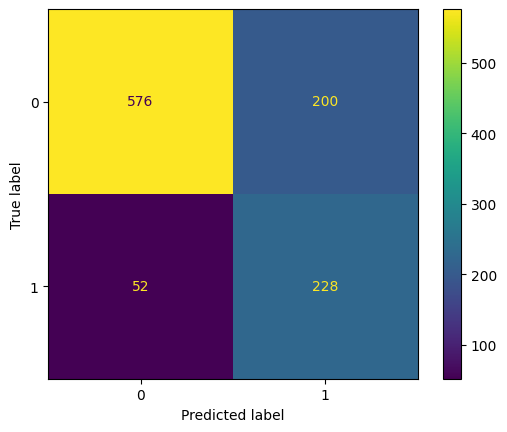

In [31]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_valid_pred)

In [32]:
print(classification_report(
    y_true = y_valid,
    y_pred = y_valid_pred,
    labels = [1,0])
)

              precision    recall  f1-score   support

           1       0.53      0.81      0.64       280
           0       0.92      0.74      0.82       776

    accuracy                           0.76      1056
   macro avg       0.72      0.78      0.73      1056
weighted avg       0.82      0.76      0.77      1056



In [33]:
y_test_pred = best_estimator.predict(X_test)

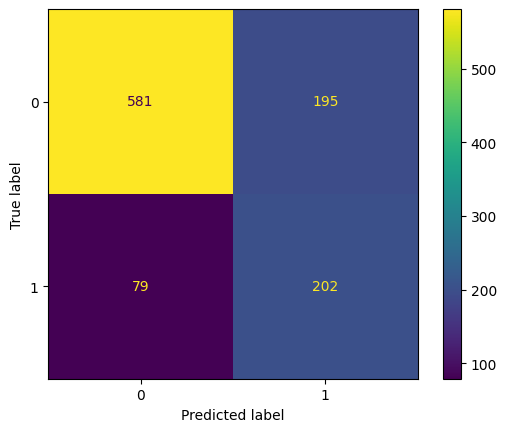

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

In [35]:
print(classification_report(
    y_true = y_test,
    y_pred = y_test_pred,
    labels = [1,0])
)

              precision    recall  f1-score   support

           1       0.51      0.72      0.60       281
           0       0.88      0.75      0.81       776

    accuracy                           0.74      1057
   macro avg       0.69      0.73      0.70      1057
weighted avg       0.78      0.74      0.75      1057



In [36]:
joblib.dump(best_estimator, params['production_model_path'])

['models/production_model.pkl']